# 数据预处理

In [10]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers.legacy import Adam
from datetime import datetime
from keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [191]:
df = pd.read_csv('/Users/harvey/Desktop/quant2/FE/final_data_20240303.csv')

In [192]:
# 找到第一个空值出现的位置
first_null_position = df.isnull().any(axis=1).idxmin()

In [193]:
df = df[first_null_position:]

In [194]:
df = df.set_index('Date')

In [195]:
df.isnull().values.any()

False

# 普通预测

In [196]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, LSTM

# 假设 df 是您的 DataFrame

# 数据准备
features = df.drop(['close', 'time', 'open', 'high', 'low'], axis=1)
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler_features.fit_transform(features)

scaler_label = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler_label.fit_transform(df[['close']])

scaled_features = np.hstack((scaled_features, scaled_close))


time_step=96*3

future_step=13

from keras import backend as K




# 修改create_dataset以预测未来48个数据点
# def create_dataset(data, time_step, future_step):
#     X, Y = [], []
#     for i in range(len(data) - time_step - future_step):
#         a = data[i:(i + time_step), :-1]  # 特征
#         X.append(a)
#         Y.append(data[(i + time_step):(i + time_step + future_step), -1])  # 'close'列的未来48个数据点
#     return np.array(X), np.array(Y)

def create_dataset(data, time_step, future_step):
    X, Y = [], []
    for i in range(len(data) - time_step - future_step):
        a = data[i:(i + time_step), :-1]  # 特征
        X.append(a)
        # 修改这里，只选择未来第future_step个数据点作为输出
        Y.append(data[i + time_step + future_step - 1, -1])  # 'close'列的未来第future_step个数据点
    return np.array(X), np.array(Y)



# 应用修改后的时间步长
X, y = create_dataset(scaled_features, time_step=time_step, future_step=future_step)

# 划分训练集和测试集
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


# model = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), kernel_initializer='glorot_uniform'),
#     LSTM(50, return_sequences=False),
#     Dense(future_step)
# ])

model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(100, return_sequences=True),
    LSTM(100),
    Dense(1)  # 修改这里，使模型只输出单一的预测结果
])


# 定义自定义损失函数
# def custom_loss(y_true, y_pred):
#     y_pred_last = y_pred[:, -1]
#     y_true_last = y_true[:, -1]
#     return K.mean(K.square(y_pred_last - y_true_last), axis=-1)




early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


# def custom_loss(y_true, y_pred):
#     weights = K.arange(1, K.shape(y_true)[-1] + 1, dtype=K.floatx())  # 加权因子
#     mse = K.square(y_pred - y_true)
#     weighted_mse = mse * weights  # 加权均方误差
#     return K.mean(weighted_mse, axis=-1)

optimizer = Adam(learning_rate=0.001, clipvalue=0.5)  # clipvalue是梯度裁剪的阈值
model.compile(optimizer=optimizer,loss='mean_squared_error')

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1, callbacks=[early_stopping])


# 预测和可视化
y_pred = model.predict(X_test)




Epoch 1/100
96/96 [==============================] - 59s 600ms/step - loss: 0.0070 - val_loss: 0.0019
Epoch 2/100
96/96 [==============================] - 56s 580ms/step - loss: 5.4685e-04 - val_loss: 0.0016
Epoch 3/100
96/96 [==============================] - 54s 561ms/step - loss: 4.8384e-04 - val_loss: 6.5652e-04
Epoch 4/100
96/96 [==============================] - 55s 575ms/step - loss: 4.7917e-04 - val_loss: 8.3393e-04
Epoch 5/100
96/96 [==============================] - 55s 572ms/step - loss: 5.2759e-04 - val_loss: 7.4049e-04
Epoch 6/100
96/96 [==============================] - 54s 559ms/step - loss: 4.5617e-04 - val_loss: 6.0946e-04
Epoch 7/100
96/96 [==============================] - 55s 569ms/step - loss: 5.0999e-04 - val_loss: 5.4193e-04
Epoch 8/100
96/96 [==============================] - 54s 566ms/step - loss: 4.7934e-04 - val_loss: 5.0892e-04
Epoch 9/100
96/96 [==============================] - 52s 546ms/step - loss: 4.3349e-04 - val_loss: 5.2106e-04
Epoch 10/100
96/96 [==

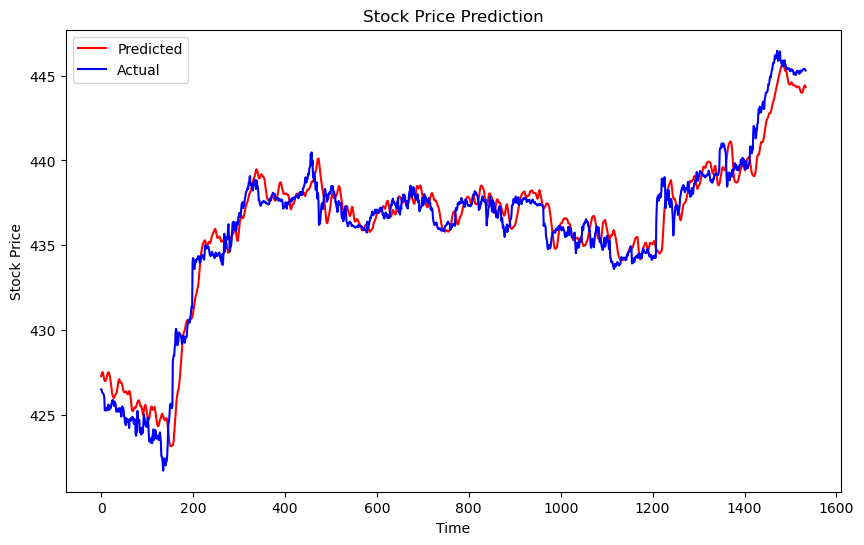

In [197]:
import matplotlib.pyplot as plt

# 由于y_pred可能是二维的，且只有一列，我们首先确保它是一维的
if y_pred.ndim > 1:
    y_pred = y_pred.squeeze()

# 逆缩放预测和测试集的数据
y_pred_rescaled = scaler_label.inverse_transform(y_pred.reshape(-1, 1))
y_test_rescaled = scaler_label.inverse_transform(y_test.reshape(-1, 1))

# 绘制预测值和实际值
plt.figure(figsize=(10, 6))  # 可以调整图形大小
plt.plot(y_pred_rescaled, label='Predicted', color='red')  # 预测值
plt.plot(y_test_rescaled, label='Actual', color='blue')  # 实际值
plt.title('Stock Price Prediction')  # 图表标题
plt.xlabel('Time')  # X轴标签
plt.ylabel('Stock Price')  # Y轴标签
plt.legend()  # 显示图例
plt.show()


In [198]:
y_pred_rescaled.shape

(1534, 1)

In [199]:
y_test_rescaled.shape

(1534, 1)

# 计算回报

In [200]:
test_df = df.iloc[test_start_position_direct:test_start_position_direct+len(y_test)]

In [201]:
test_df

,time,open,high,low,close,volume,SMA_5,SMA_10,SMA_20,SMA_50,...,%K,%D,VWAP,ATR,Momentum_5,Momentum_10,Momentum_15,Momentum_20,Momentum_50,Momentum_100
Date,,,,,,,,,,,,,,,,,,,,,
2024-02-20 18:20:00,2024-02-20T18:20:00,426.70,426.70,426.63,426.64,2039,426.5822,426.4131,426.450555,426.372932,...,80.701754,80.116959,418.664871,0.208469,0.360,0.33,0.1400,-0.28,1.3300,1.03
2024-02-20 18:25:00,2024-02-20T18:25:00,426.65,426.74,426.64,426.68,8812,426.6162,426.4601,426.443555,426.392722,...,87.719298,84.795322,418.664915,0.200721,0.170,0.47,0.3300,-0.14,0.9895,1.21
2024-02-20 18:30:00,2024-02-20T18:30:00,426.71,426.71,426.51,426.53,9025,426.6240,426.4931,426.428555,426.421120,...,61.403509,76.608187,418.664960,0.200669,0.039,0.33,0.0900,-0.30,1.4199,1.48
2024-02-20 18:35:00,2024-02-20T18:35:00,426.51,426.53,426.39,426.39,4547,426.5820,426.5091,426.419055,426.436320,...,36.842105,61.988304,418.664983,0.196336,-0.210,0.16,0.0899,-0.19,0.7600,1.04
2024-02-20 18:40:00,2024-02-20T18:40:00,426.32,426.32,426.29,426.29,1889,426.5060,426.5081,426.408055,426.456520,...,16.363636,38.203083,418.664992,0.189455,-0.380,-0.01,0.0500,-0.22,1.0100,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-01 18:15:00,2024-03-01T18:15:00,445.26,445.26,445.26,445.26,1028,445.2340,445.1700,445.232000,445.579060,...,68.652038,60.671708,421.645056,0.145871,0.210,0.18,-0.1100,-0.14,-0.7300,4.45
2024-03-01 18:20:00,2024-03-01T18:20:00,445.20,445.21,445.20,445.20,1441,445.2420,445.1770,445.221500,445.559260,...,54.669084,59.563328,421.645074,0.139738,0.040,0.07,-0.1700,-0.21,-0.9900,4.57
2024-03-01 18:25:00,2024-03-01T18:25:00,445.15,445.21,445.11,445.11,613,445.2080,445.1780,445.214000,445.537560,...,27.470535,50.263886,421.645081,0.136899,-0.170,0.01,-0.1700,-0.15,-1.0850,3.36


In [202]:
pd.DataFrame(scaler_features.inverse_transform(X_test[-1,:,:]))

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,440991.0,437.964,438.2200,438.226065,436.319032,435.352336,435.218594,438.082072,438.104650,437.869104,...,56.444444,46.222222,420.837821,0.576337,1.110,-0.190,0.3800,0.660,3.7200,4.040
1,384894.0,437.964,438.1060,438.214565,436.380432,435.386736,435.232994,437.938048,438.021986,437.848237,...,28.000000,42.518519,420.841378,0.593027,0.000,-1.140,-0.5500,-0.230,3.0700,3.440
2,494851.0,438.014,438.0520,438.228065,436.453232,435.426636,435.250147,438.038699,438.061625,437.885548,...,57.009346,47.151263,420.845992,0.622811,0.250,-0.540,-0.6900,0.270,3.6400,3.990
3,281592.0,437.919,437.8925,438.196815,436.510932,435.458176,435.261572,437.834132,437.945875,437.841686,...,18.925234,34.644860,420.848572,0.641896,-0.475,-1.595,-1.1350,-0.625,2.8850,3.154
4,360218.0,437.838,437.7900,438.185565,436.571832,435.491416,435.274096,437.751088,437.880261,437.817240,...,26.401869,34.112150,420.851832,0.633546,-0.405,-1.025,-0.9463,-0.225,3.0450,3.324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,5904.0,445.192,445.1520,445.239000,445.593660,444.547234,442.094313,445.210081,445.203960,445.259293,...,55.368863,60.619585,421.645043,0.154785,0.040,0.000,-0.1100,-0.140,-0.9600,4.810
284,1028.0,445.234,445.1700,445.232000,445.579060,444.591734,442.125264,445.226721,445.214149,445.259360,...,68.652038,60.671708,421.645056,0.145871,0.210,0.180,-0.1100,-0.140,-0.7300,4.450
285,1441.0,445.242,445.1770,445.221500,445.559260,444.637434,442.155614,445.217814,445.211576,445.253707,...,54.669084,59.563328,421.645074,0.139738,0.040,0.070,-0.1700,-0.210,-0.9900,4.570
286,613.0,445.208,445.1780,445.214000,445.537560,444.671034,442.185251,445.181876,445.193108,445.240020,...,27.470535,50.263886,421.645081,0.136899,-0.170,0.010,-0.1700,-0.150,-1.0850,3.360


In [203]:
pd.DataFrame(scaler_features.inverse_transform(X_train[-1,:,:]))

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,1181054.0,433.4080,434.24900,434.82600,436.044176,436.009792,434.931869,433.084401,433.850377,434.603564,...,1.160093,2.092843,417.969687,0.664581,-3.670,-3.9700,-3.5700,-3.228,-6.0500,-4.041
1,1190248.0,432.7620,433.83900,434.54750,435.924376,435.970292,434.918269,432.472934,433.377581,434.284177,...,11.111111,4.854927,417.980248,0.672468,-3.230,-4.1000,-3.6500,-5.570,-5.9900,-3.950
2,1605038.0,432.0560,433.38200,434.25800,435.795168,435.923892,434.901919,431.871956,432.885293,433.939970,...,14.539007,8.936737,417.993828,0.724434,-3.530,-4.5700,-3.7300,-5.790,-6.4604,-4.640
3,709225.0,431.5040,432.97000,433.98150,435.673360,435.880492,434.886369,431.584637,432.544331,433.660925,...,20.567376,15.405831,417.999934,0.726260,-2.760,-4.1200,-3.8400,-5.530,-6.0904,-4.340
4,684583.0,431.0300,432.58600,433.78900,435.552560,435.837392,434.871719,431.386425,432.261725,433.406551,...,20.212766,18.439716,418.005894,0.731170,-2.370,-3.8400,-4.2300,-3.850,-6.0400,-4.310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,430.0,426.2500,426.30801,426.53000,426.206512,425.720172,427.350426,426.270356,426.333686,426.397983,...,15.384615,7.939450,418.664096,0.243840,0.060,-0.2100,-0.6999,-0.250,1.3400,-2.770
284,14425.0,426.2440,426.28601,426.51800,426.234312,425.705532,427.332076,426.273571,426.323925,426.386747,...,14.084507,11.831073,418.664166,0.231423,-0.030,-0.2200,-0.6400,-0.240,1.3900,-1.464
285,63332.0,426.3040,426.30201,426.50850,426.265312,425.704532,427.314676,426.352380,426.357757,426.398485,...,54.098361,27.855828,418.664475,0.235607,0.300,0.1600,-0.3100,-0.190,1.5500,-0.100
286,9507.0,426.3622,426.30711,426.49405,426.287132,425.703542,427.297031,426.398587,426.381983,426.407296,...,70.681818,46.288229,418.664522,0.225920,0.291,0.0510,-0.3390,-0.289,1.0910,-0.099


In [204]:
test_df['predicted_close_in1h'] = y_pred_rescaled.squeeze()
test_df['actual_close_in1h'] = y_test_rescaled.squeeze()

/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_41353/1096888416.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['predicted_close_in1h'] = y_pred_rescaled.squeeze()
/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_41353/1096888416.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['actual_close_in1h'] = y_test_rescaled.squeeze()


In [205]:
df_1h_magnify = test_df[['close','actual_close_in1h','predicted_close_in1h']]

In [206]:
df_1h_magnify['true_updown_in1h'] = df_1h_magnify['actual_close_in1h']/df_1h_magnify['close'] - 1
df_1h_magnify['predict_updown_in1h'] = df_1h_magnify['predicted_close_in1h']/df_1h_magnify['close'] - 1

/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_41353/2636791147.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1h_magnify['true_updown_in1h'] = df_1h_magnify['actual_close_in1h']/df_1h_magnify['close'] - 1
/var/folders/t2/vmnkmyxs42b6h_fbsdjtsp0c0000gn/T/ipykernel_41353/2636791147.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1h_magnify['predict_updown_in1h'] = df_1h_magnify['predicted_close_in1h']/df_1h_magnify['close'] - 1


In [215]:
df_1h_magnify['close'].shift(-12) == df_1h_magnify['actual_close_in1h']

Date
2024-02-20 18:20:00     True
2024-02-20 18:25:00    False
2024-02-20 18:30:00     True
2024-02-20 18:35:00    False
2024-02-20 18:40:00     True
                       ...  
2024-03-01 18:15:00    False
2024-03-01 18:20:00    False
2024-03-01 18:25:00    False
2024-03-01 18:30:00    False
2024-03-01 18:40:00    False
Length: 1534, dtype: bool

In [209]:
df_1h_magnify = df_1h_magnify.dropna(how='any')

df_1h_magnify['direction_same'] = (df_1h_magnify['true_updown_in1h'] * df_1h_magnify['predict_updown_in1h']) > 0

# 计算方向相同的次数
direction_same_count = df_1h_magnify['direction_same'].sum()

direction_same_count/len(df_1h_magnify)

0.49934810951760106

In [210]:
df_1h_magnify.to_csv('test.csv')

In [211]:
df_1h_magnify['true_updown_in1h'].quantile(0.25)

-0.0007723217439450647

In [212]:
df_1h_magnify['true_updown_in1h'].quantile(0.75)

0.0012204740285987614

In [213]:
df_1h_magnify

,close,actual_close_in1h,predicted_close_in1h,true_updown_in1h,predict_updown_in1h,direction_same
Date,,,,,,
2024-02-20 18:20:00,426.64,426.5100,427.286926,-3.047065e-04,0.001516,False
2024-02-20 18:25:00,426.68,426.4799,427.397369,-4.689697e-04,0.001681,False
2024-02-20 18:30:00,426.53,426.3400,427.491730,-4.454552e-04,0.002255,False
2024-02-20 18:35:00,426.39,426.3000,427.524445,-2.110744e-04,0.002661,False
2024-02-20 18:40:00,426.29,426.2800,427.467560,-2.345821e-05,0.002762,False
...,...,...,...,...,...,...
2024-03-01 18:15:00,445.26,445.4000,444.308624,3.144230e-04,-0.002137,False
2024-03-01 18:20:00,445.20,445.3900,444.388397,4.267745e-04,-0.001823,False
2024-03-01 18:25:00,445.11,445.4000,444.430725,6.515243e-04,-0.001526,False


# 模型表现

In [154]:
#config

buy_threshold = 0.0002
sell_threshold = -0.0003

In [216]:
# 初始化资金和仓位
initial_capital = 1000
buy_unit = 1000
capital = initial_capital
position = 0  # 当前仓位，正数为持有，负数为卖空
trade_count = 0  # 交易次数
waiting_period = 0  # 等待期间的计数器，用于自动平仓
capital_list = []
total_asset_list = []  # 资产总价值列表

for index, row in df_1h_magnify.iterrows():
    predict_change_rate = row['predict_updown_in1h']
    
    # 每五分钟检查一次，如果有持仓且等待期间到了，自动平仓
    if waiting_period > 0:
        waiting_period -= 1
        if waiting_period == 0 and position != 0:
            capital += position * row['close']
            position = 0  # 清仓

    # 买入信号处理
    if predict_change_rate > buy_threshold:
        if position <= 0:  # 如果仓位为负或为0，则买入
            if position < 0:
                # 如果已有持仓，则先平仓
                capital += position * row['close']
            # 买入
            position = buy_unit / row['close']
            capital -= position * row['close']
            waiting_period = 12  # 设置等待期间为12个时间点，即一个小时
            trade_count += 1
        else:
            # 仓位为正，重置等待期间
            waiting_period = 12

    # 卖出信号处理
    elif predict_change_rate < sell_threshold:
        if position >= 0:  # 如果仓位为正或为0，则卖空
            if position > 0:
                # 如果已有持仓，则先平仓
                capital += position * row['close']
            # 卖空
            position = -buy_unit / row['close']
            capital += abs(position) * row['close']
            waiting_period = 12  # 设置等待期间为12个时间点，即一个小时
            trade_count += 1
        else:
            # 仓位为负，重置等待期间
            waiting_period = 12
    total_asset_value = capital + (position * row['close'])
    total_asset_list.append(total_asset_value)
        
    # 检查是否是DataFrame的最后一行
    if index == df_1h_magnify.index[-1] and position != 0:
        # 如果是最后一期，则关闭所有仓位
        capital += position * row['close']
        position = 0  # 清仓
    capital_list.append(capital)

# 计算总回报
total_return = capital - initial_capital
df_1h_magnify['capital_list'] = capital_list
df_1h_magnify['total_asset_list'] = total_asset_list

In [217]:
total_return

9.191071791812647

In [157]:
df_1h_magnify['capital_list'][-1]/1000-1

-0.0020046978713262886

In [158]:
df_1h_magnify['close'][-1]/df_1h_magnify['close'][0] -1

0.043643352709544336

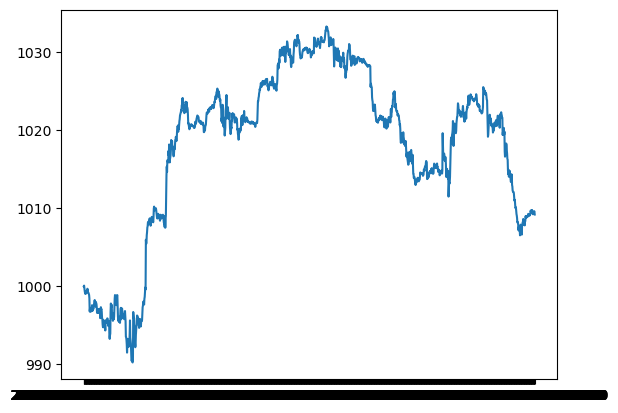

In [220]:
plt.plot(df_1h_magnify.index,df_1h_magnify['total_asset_list'])

In [221]:
import numpy as np

# 假设 df_1h_magnify['close'] 存在且已经有了 total_asset_list
close_prices = df_1h_magnify['close'].values
normalized_close_prices = close_prices / close_prices[0]  # 归一化收盘价

total_assets = np.array(total_asset_list)
normalized_total_assets = total_assets / total_assets[0]  # 归一化资产总价值

# 更新DataFrame，以便比较
df_1h_magnify['normalized_close'] = normalized_close_prices
df_1h_magnify['normalized_total_assets'] = normalized_total_assets

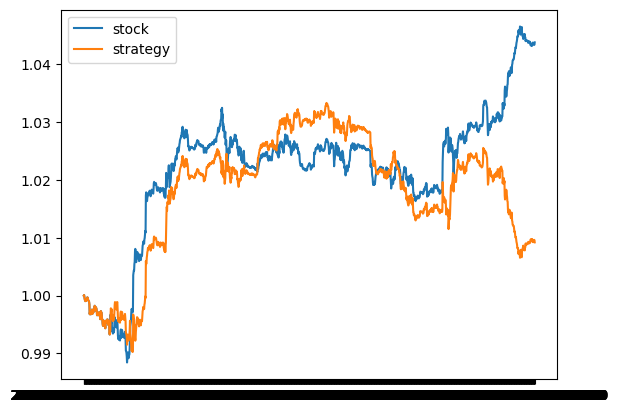

In [224]:
plt.plot(df_1h_magnify.index,df_1h_magnify['normalized_close'],label = 'stock')
plt.plot(df_1h_magnify.index,df_1h_magnify['normalized_total_assets'],label = 'strategy')
plt.legend()